In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro import infer, poutine
from pyro.contrib.gp import Parameterized
import pyro.contrib.gp as gp
plt.style.use("seaborn-v0_8")

/env_nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Regression

In [2]:
def reset(seed=False, param=False):
    if param:
        pyro.clear_param_store()
    if seed:
        pyro.set_rng_seed(0)

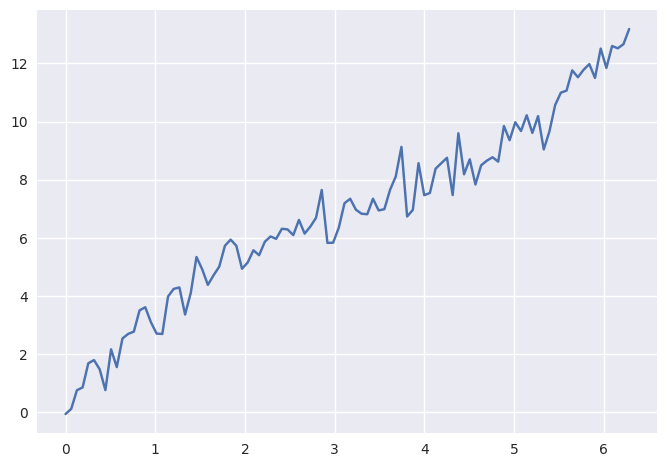

In [3]:
reset(seed=True, param=True)
N = 100
X = torch.linspace(0, 2*np.pi, N)
y = torch.sin(X) + 2. * X + torch.normal(mean=torch.empty(N).fill_(0.5), std=torch.empty(N).fill_(0.5))
plt.plot(X, y)

In [4]:
periodic_kernel = gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1), lengthscale=torch.tensor(0.5))
lin_kernel = gp.kernels.Linear(1, torch.tensor(1.))
kernel = gp.kernels.Sum(periodic_kernel, lin_kernel)

In [5]:
model = gp.models.GPRegression(X, y, kernel=kernel, noise=torch.tensor(1e-3))

In [6]:
model.kernel.kern0.variance_unconstrained, model.kernel.kern0.lengthscale_unconstrained

(Parameter containing:
 tensor(0., requires_grad=True),
 Parameter containing:
 tensor(-0.6931, requires_grad=True))

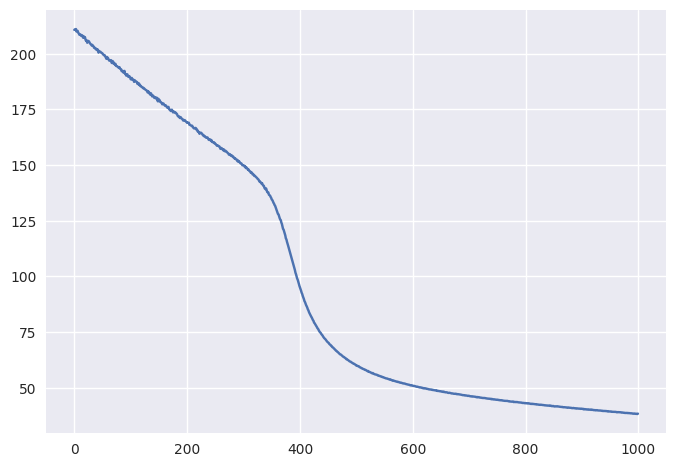

In [7]:
reset(True, True)
model = gp.models.GPRegression(X, y, kernel=kernel, noise=torch.tensor(1e-3))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
elbo = infer.Trace_ELBO()
loss_fn = elbo.differentiable_loss
losses = []
for i in range(1000):
    loss = loss_fn(model.model, model.guide) / N
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)

In [8]:
model.kernel.kern0.variance_unconstrained, model.kernel.kern0.lengthscale_unconstrained

(Parameter containing:
 tensor(1.0005, requires_grad=True),
 Parameter containing:
 tensor(-1.6741, requires_grad=True))

In [9]:
yhat_mean, yhat_cov = model(X, full_cov=True, noiseless=True)

In [10]:
yhat_mean

tensor([ 0.3824,  0.4216,  1.0342,  0.9826,  1.5397,  0.8740,  1.2958,  1.4919,
         2.2533,  1.7409,  2.4752,  2.4180,  2.8028,  3.4102,  3.2646,  3.1432,
         2.8209,  3.1388,  3.5444,  3.7626,  4.2624,  3.6057,  3.9184,  4.7495,
         4.8185,  4.6188,  4.8478,  4.9526,  5.5778,  6.2286,  5.3433,  4.8034,
         4.9473,  5.5462,  5.8099,  5.9982,  6.0494,  5.7423,  6.3375,  6.5198,
         6.1580,  6.4550,  6.3558,  7.0236,  6.7111,  7.1259,  6.5159,  6.0440,
         6.4082,  7.1330,  7.2335,  7.2289,  6.6796,  7.3684,  7.3979,  7.1146,
         6.8537,  7.4669,  7.5687,  8.2336,  6.8949,  7.5616,  7.8221,  7.4600,
         7.6233,  8.3840,  8.2463,  8.3766,  7.5801,  8.7778,  8.0677,  8.4239,
         8.1328,  8.9413,  9.2187,  9.3680,  8.4781,  9.3118,  9.9078,  9.4500,
         9.4478, 10.1312, 10.0008, 10.4773,  9.7677, 10.4145, 10.2503, 11.1166,
        10.5899, 11.4067, 11.4352, 11.6674, 12.0106, 12.1869, 12.2688, 11.8489,
        12.0657, 12.5338, 12.6971, 13.26

In [11]:
yhat_cov

tensor([[ 6.5947e-04,  8.2850e-05,  7.8875e-05,  ..., -7.2138e-05,
         -8.0145e-05, -7.5888e-05],
        [ 8.2850e-05,  6.5780e-04,  8.2225e-05,  ..., -1.0514e-04,
         -7.6860e-05, -8.3327e-05],
        [ 7.8875e-05,  8.2225e-05,  6.5851e-04,  ...,  3.0708e-04,
         -1.1092e-04, -7.2300e-05],
        ...,
        [-7.2138e-05, -1.0496e-04,  3.0661e-04,  ...,  6.4850e-04,
          9.1553e-05,  7.6294e-05],
        [-8.0145e-05, -7.6860e-05, -1.1092e-04,  ...,  9.1553e-05,
          6.6376e-04,  8.7738e-05],
        [-7.5887e-05, -8.3327e-05, -7.2062e-05,  ...,  7.6294e-05,
          8.7738e-05,  6.5994e-04]], grad_fn=<ExpandBackward0>)

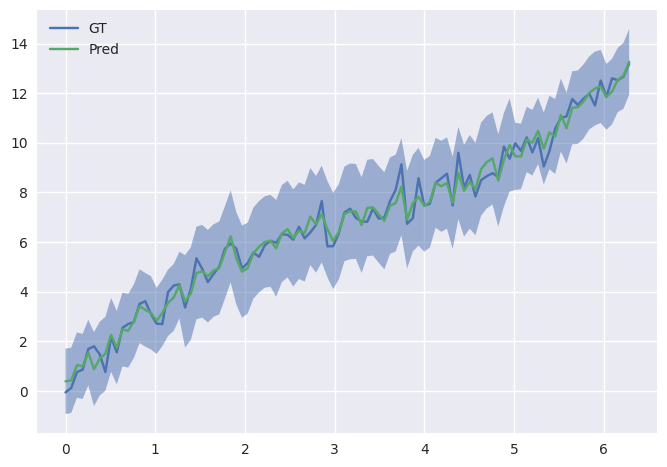

In [12]:
fig, ax = plt.subplots()

ax.plot(X, y, label="GT")
ax.plot(X, yhat_mean.detach(), label="Pred")
ax.fill_between(X, 
                yhat_mean.detach() - 2000 * torch.diagonal(yhat_cov.detach()), 
                yhat_mean.detach() + 2000 * torch.diagonal(yhat_cov.detach()),
                alpha=0.5
                )
ax.legend()

In [13]:
yhat_mean.detach() + 100 * torch.diagonal(yhat_cov.detach())

tensor([ 0.4484,  0.4874,  1.1000,  1.0482,  1.6059,  0.9485,  1.3703,  1.5663,
         2.3277,  1.8151,  2.5496,  2.4923,  2.8771,  3.4846,  3.3388,  3.2171,
         2.8876,  3.2059,  3.6114,  3.8300,  4.3296,  3.6989,  4.0119,  4.8428,
         4.9118,  4.7121,  4.9410,  5.0463,  5.6711,  6.3215,  5.4364,  4.8963,
         5.0389,  5.6379,  5.9019,  6.0904,  6.1420,  5.8397,  6.4355,  6.6171,
         6.2559,  6.5524,  6.4533,  7.1214,  6.8084,  7.2234,  6.6129,  6.1409,
         6.5045,  7.2285,  7.3300,  7.3246,  6.7760,  7.4656,  7.4952,  7.2121,
         6.9517,  7.5642,  7.6662,  8.3312,  6.9933,  7.6591,  7.9205,  7.5525,
         7.7156,  8.4746,  8.3380,  8.4687,  7.6732,  8.8709,  8.1603,  8.5183,
         8.2260,  9.0351,  9.3120,  9.4609,  8.5712,  9.4062, 10.0014,  9.5177,
         9.5138, 10.1970, 10.0670, 10.5442,  9.8402, 10.4885, 10.3258, 11.1902,
        10.6612, 11.4803, 11.5092, 11.7422, 12.0842, 12.2613, 12.3425, 11.9153,
        12.1317, 12.5987, 12.7635, 13.33

## Classification

In [14]:
reset(True, True)
nclass = 3
d = 2
N = 30 * nclass
centers = torch.empty(nclass, d).uniform_(-5, 5)
clusters = [dist.Normal(centers[i], torch.Tensor(1).uniform_(0, 1)).to_event(1).sample((N// nclass, )) for i in range(nclass)]

In [15]:
xclass, yclass = [], []
for i in range(nclass):
    xclass.extend(clusters[i])
    yclass.extend([torch.tensor(i).long()] * len(clusters[i]))
xclass = torch.vstack(xclass)
yclass = torch.vstack(yclass).squeeze()

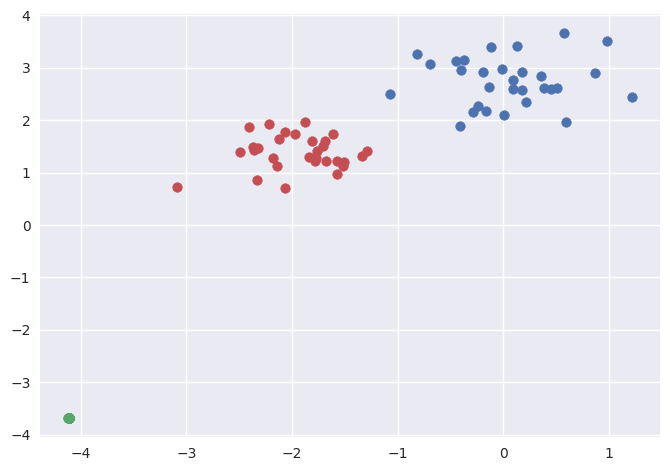

In [16]:
for i, c in enumerate(clusters):
    a, b = c.unbind(1)
    plt.scatter(a, b)

In [17]:
indices = torch.randperm(N)
xlass = xclass.index_select(0, indices)
yclass = yclass[indices]

In [18]:
xclass.size(), yclass.size()

(torch.Size([90, 2]), torch.Size([90]))

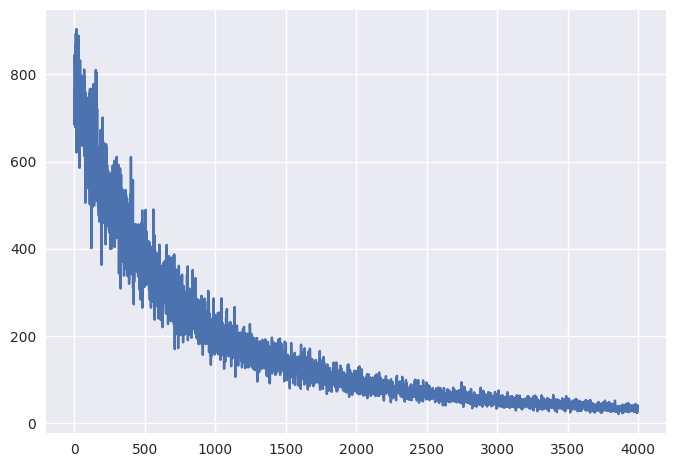

In [19]:
reset(True, True)
likelihood = gp.likelihoods.MultiClass(nclass)
kernel = gp.kernels.Matern32(input_dim=d, variance=torch.tensor(1.0), 
                             lengthscale=torch.tensor(1.0))
model = gp.models.VariationalGP(xclass, yclass, 
                                kernel=periodic_kernel,
                                likelihood=likelihood, 
                                latent_shape=(nclass,),
                                jitter=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
elbo = infer.Trace_ELBO()
loss_fn = elbo.differentiable_loss
losses = []
for i in range(4000):
    loss = loss_fn(model.model, model.guide) / N
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)

In [20]:
model.set_mode("guide")

In [21]:
mean, cov = model(xclass)

In [22]:
pred = torch.vstack([likelihood(mean, cov) for _ in range(1000)])

In [23]:
pred.size()

torch.Size([1000, 90])

In [24]:
pred = pred.t()

In [25]:
pred.size()

torch.Size([90, 1000])

In [26]:
pred

tensor([[0, 0, 2,  ..., 0, 1, 0],
        [2, 1, 1,  ..., 1, 0, 1],
        [0, 2, 2,  ..., 0, 1, 0],
        ...,
        [1, 1, 0,  ..., 2, 2, 1],
        [1, 0, 2,  ..., 1, 0, 0],
        [2, 1, 2,  ..., 2, 1, 2]])

In [27]:
p = []
for i in range(pred.size(0)):
    c = {}
    for j in range(nclass):
        c[j] = (pred[i] == j).sum()
    maxval = max(c, key=lambda x: c[x])
    p.append(maxval)

p = torch.tensor(p)

In [28]:
p

tensor([1, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 1, 2, 1, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0,
        1, 0, 0, 2, 1, 1, 1, 0, 1, 1, 2, 1, 2, 0, 1, 0, 2, 1, 0, 0, 0, 2, 0, 0,
        0, 1, 1, 1, 0, 1, 0, 2, 2, 1, 0, 1, 2, 0, 1, 1, 1, 2, 0, 1, 0, 1, 1, 0,
        1, 1, 1, 2, 1, 1, 1, 0, 0, 1, 2, 1, 0, 1, 0, 0, 1, 0])

In [29]:
acc = (p == yclass).sum() / N
acc *= 100.
print(acc) 

tensor(51.1111)


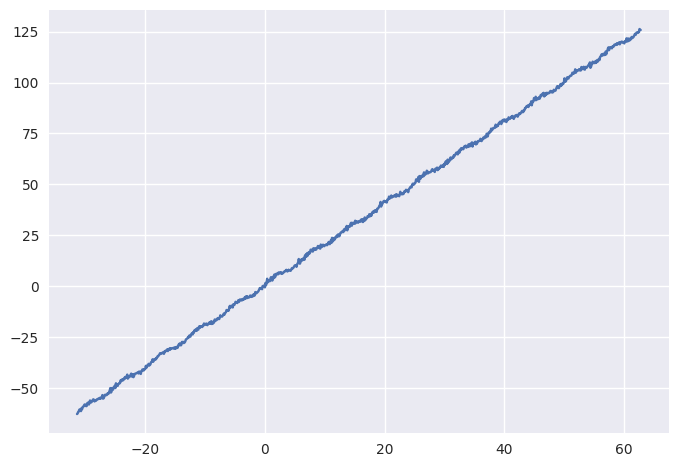

In [30]:
reset(seed=True, param=True)
N = 1000
X = torch.linspace(-10 * np.pi, 20 * np.pi, N)
y = torch.sin(X) + 2. * X + torch.normal(mean=torch.empty(N).fill_(0.5), std=torch.empty(N).fill_(0.5))
plt.plot(X, y)

tensor([-0.0749,  5.3644, -8.2305, -7.3594, -3.8515,  2.6816, -0.1981,  7.9289,
        -0.8874,  2.6461])


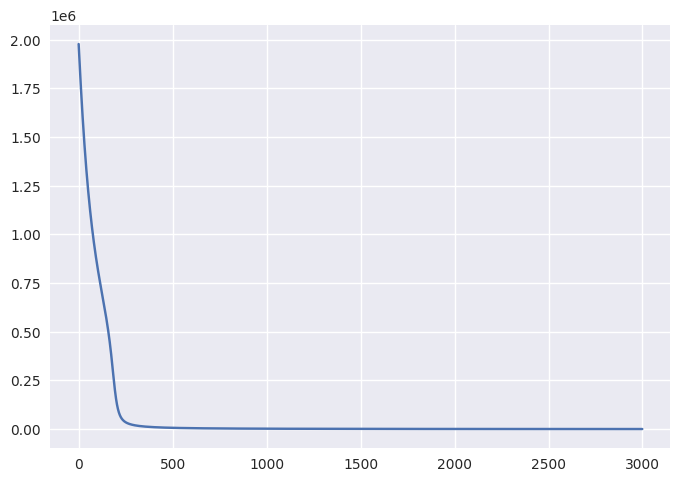

In [31]:
reset(True, True)
Xu = torch.empty((10,)).uniform_(-10, 10)
print(Xu)
model = gp.models.SparseGPRegression(X, 
                                     y,
                                     Xu=Xu, 
                                     kernel=kernel, 
                                     noise=torch.tensor(1e-3),
                                     jitter=torch.tensor(1e-3))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
elbo = infer.Trace_ELBO()
loss_fn = elbo.differentiable_loss
losses = []
for i in range(3000):
    loss = loss_fn(model.model, model.guide) / N
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)

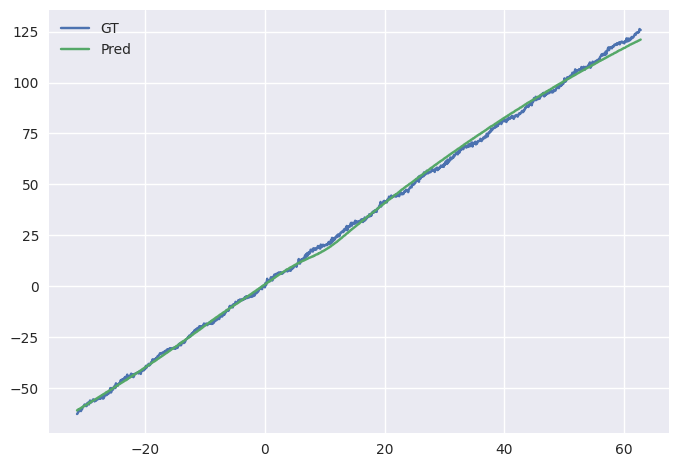

In [32]:
with torch.no_grad():
    mean, var = model(X)
fig, ax = plt.subplots()

ax.plot(X, y, label="GT")
ax.plot(X, mean, label="Pred")
ax.legend()

In [33]:
model.Xu

Parameter containing:
tensor([  0.5689,  10.4885, -10.5665,  -8.9684,  -6.0782,   6.2767,  -1.5678,
         13.6778,  -2.8569,   5.1754], requires_grad=True)

In [34]:
Xu

tensor([  0.5689,  10.4885, -10.5665,  -8.9684,  -6.0782,   6.2767,  -1.5678,
         13.6778,  -2.8569,   5.1754])